# Sentiment Analysis using LSTM

## What is Sentiment Analysis:
the process of computationally identifying and categorizing opinions expressed in a piece of text, especially in order to determine whether the writer's attitude towards a particular topic, product, etc. is positive, negative, or neutral.

I think this result from google dictionary gives a very succinct definition. I don’t have to re-emphasize how important sentiment analysis has become. So, here we will build a classifier on IMDB movie dataset using a Deep Learning technique called RNN.

I’m outlining a step-by-step process for how Recurrent Neural Networks (RNN) can be implemented using Long Short Term Memory (LSTM) architecture:

1. Load in and visualize the data
2. Data Processing — convert to lower case, Remove punctuation etc.
5. Tokenize — Create Vocab to Int mapping dictionary
6. Tokenize — Encode the words
7. Tokenize — Encode the labels
8. Analyze Reviews Length
9. Removing Outliers — Getting rid of extremely long or short reviews
10. Padding / Truncating the remaining data
11. Training, Validation, Test Dataset Split
12. Dataloaders and Batching
13. Define the LSTM Network Architecture
14. Define the Model Class
15. Training the Network
16. Testing

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
from collections import Counter
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn

# from classification.model import EmbeddingAL, LSTMAL

In [2]:
from classification.model import EmbeddingAL, LSTMAL

In [3]:
def get_n_params(model):
    pp = 0
    for p in list(model.parameters()):
        nn = 1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

## 1) Load in and visualize the data

In [4]:
df = pd.read_csv('IMDB_Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## 2) Data Processing — convert to lower case, Remove punctuation etc

In [5]:
def data_preprocessing(text):
    text = text.lower()
    text = re.sub('<.*?>', '', text) # Remove HTML from text
    text = ''.join([c for c in text if c not in string.punctuation])# Remove punctuation
    text = [word for word in text.split() if word not in stop_words]
    text = ' '.join(text)
    return text

## 5) Tokenize — Create Vocab to Int mapping dictionary
In most of the NLP tasks, you will create an index mapping dictionary in such a way that your frequently occurring words are assigned lower indexes. One of the most common way of doing this is to use Counter method from Collections library.

In [6]:
df['cleaned_reviews'] = df['review'].apply(data_preprocessing)
corpus = [word for text in df['cleaned_reviews'] for word in text.split()]
count_words = Counter(corpus)
sorted_words = count_words.most_common()

There is a small trick here, in this mapping index will start from 0 i.e. mapping of ‘the’ will be 0. But later on we are going to do padding for shorter reviews and conventional choice for padding is 0. So we need to start this indexing from 1

In [7]:
vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

reviews_int = []
for text in df['cleaned_reviews']:
    r = [vocab_to_int[word] for word in text.split()]
    reviews_int.append(r)

# print(reviews_int[:1])
df['Review int'] = reviews_int

## 7) Tokenize — Encode the labels
This is simple because we only have 2 output labels. So, we will just label ‘positive’ as 1 and ‘negative’ as 0

In [8]:
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
# df.head()

## 8) Analyze Reviews Length

In [9]:
review_len = [len(x) for x in reviews_int]
df['Review len'] = review_len
# df.head()

count    50000.000000
mean       119.855700
std         90.096619
min          3.000000
25%         64.000000
50%         89.000000
75%        146.000000
max       1429.000000
Name: Review len, dtype: float64


<AxesSubplot:>

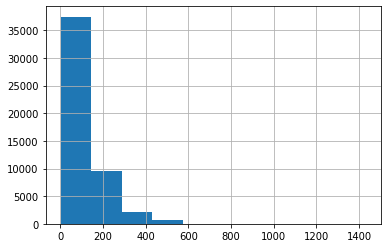

In [10]:
print(df['Review len'].describe())

df['Review len'].hist()
# plt.title('Review length distribution', size=15)
# plt.show()

<b>Observations : </b>a) Mean review length = 226 b) Most of the reviews less than 500 words or more d) There are quite a few reviews that are extremely long, we can manually investigate them to check whether we need to include or exclude them from our analysis

## 10) Padding / Truncating the remaining data
To deal with both short and long reviews, we will pad or truncate all our reviews to a specific length. We define this length by Sequence Length. This sequence length is same as number of time steps for LSTM layer.

For reviews shorter than seq_length, we will pad with 0s. For reviews longer than seq_length we will truncate them to the first seq_length words.

In [11]:
def Padding(review_int, seq_len):
    '''
    Return features of review_ints, where each review is padded with 0's or truncated to the input seq_length.
    '''
    features = np.zeros((len(reviews_int), seq_len), dtype = int)
    for i, review in enumerate(review_int):
        if len(review) <= seq_len:
            zeros = list(np.zeros(seq_len - len(review)))
            new = zeros + review
        else:
            new = review[: seq_len]
        features[i, :] = np.array(new)
            
    return features

In [12]:
features = Padding(reviews_int, 200)

## 11) Training, Validation, Test Dataset Split
Once we have got our data in nice shape, we will split it into training, validation and test sets

<b>train= 80% | valid = 10% | test = 10% </b>

In [13]:
X_train, X_remain, y_train, y_remain = train_test_split(features, df['sentiment'].to_numpy(), test_size=0.2, random_state=1)
X_valid, X_test, y_valid, y_test = train_test_split(X_remain, y_remain, test_size=0.5, random_state=1)

## 12) Dataloaders and Batching
After creating our training, test and validation data. Next step is to create dataloaders for this data. We can use generator function for batching our data into batches instead we will use a TensorDataset. This is one of a very useful utility in PyTorch for using our data with DataLoaders with exact same ease as of torchvision datasets

In [14]:
# create tensor dataset
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))

# dataloaders
batch_size = 16

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [15]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

## 13) Define the LSTM Network Architecture

<img src='https://miro.medium.com/max/700/1*SICYykT7ybua1gVJDNlajw.png'>

The layers are as follows:

0. Tokenize : This is not a layer for LSTM network but a mandatory step of converting our words into tokens (integers)
1. Embedding Layer: that converts our word tokens (integers) into embedding of specific size
2. LSTM Layer: defined by hidden state dims and number of layers
3. Fully Connected Layer: that maps output of LSTM layer to a desired output size
4. Sigmoid Activation Layer: that turns all output values in a value between 0 and 1
5. Output: Sigmoid output from the last timestep is considered as the final output of this network


## 14) Define the Model Class

In [24]:
class SentAL(nn.Module):
    def __init__(self, emb, l1, l2):
        super(SentAL, self).__init__()
        self.embedding = emb
        self.layer_1 = l1
        self.layer_2 = l2
    def forward(self, x, y):
        emb_x, emb_y, = self.embedding(x, y)
        print(self.embedding._t_prime.shape, self.embedding.y.shape)
        emb_loss = self.embedding.loss()
        
        layer_1_x, h1, layer_1_y = self.layer_1(emb_x, emb_y)
        layer_1_loss = self.layer_1.loss()

        h,c = h1
        print('old', h.shape, c.shape)
        h = h.reshape(h.size(0), h.size(1), 2, -1)
        h = h[:,:,0,:] + h[:,:,1,:]
        c = c.reshape(c.size(0), c.size(1), 2, -1)
        c = c[:,:,0,:] + c[:,:,1,:]
        print('new', h.shape, c.shape)
        h1 = (h,c)

        layer_2_x, h2, layer_2_y = self.layer_2(layer_1_x, layer_1_y, h1)
        layer_2_loss = self.layer_2.loss()

        return emb_loss, layer_1_loss, layer_2_loss


In [21]:
torch.cuda.empty_cache()

In [25]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda:1")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

# Instantiate the model w/ hyperparams
vocab_size = len(vocab_to_int) + 1
output_size = 1
embedding_dim = 300
hidden_dim = 400
n_layers = 2

emb = EmbeddingAL((vocab_size, 2), (300, 128))
l1 = LSTMAL(300,128, (128,128), dropout=0.2, bidirectional=True)
l2 = LSTMAL(128, 128, (64, 64), dropout=0.2, bidirectional=True)

model = SentAL(emb, l1, l2)
model = model.to(device)
print(get_n_params(model))

GPU is available
135339663


/home/hibb1126/.local/lib/python3.6/site-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


## Training Loop

In [27]:
lr=0.001

criterion = nn.BCELoss()

# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer_1 = torch.optim.Adam(model.embedding.parameters(), lr=1e-4)
optimizer_2 = torch.optim.Adam(model.layer_1.parameters(), lr=1e-4)
optimizer_3 = torch.optim.Adam(model.layer_2.parameters(), lr=1e-4)
# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

clip = 5
epochs = 10
valid_acc_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []

    total_emb_loss = []
    total_l1_loss = []
    total_l2_loss = []

    total_acc = 0.0
    total_count = 0
    model.embedding.train()
    model.layer_1.train()
    model.layer_2.train()

    # initialize hidden state 
    for inputs, labels in train_loader:
        
        print(labels.shape)

        inputs, labels = inputs.to(device), labels.to(device)   
        
        model.zero_grad()
        emb_loss, l1_loss, l2_loss = model(inputs,labels)
        
        nn.utils.clip_grad_norm_(model.parameters(), clip)

        total_emb_loss.append(emb_loss.item())
        total_l1_loss.append(l1_loss.item())
        total_l2_loss.append(l2_loss.item())

        emb_loss.backward()
        optimizer_1.step()

        l1_loss.backward()
        optimizer_2.step()

        l2_loss.backward()
        optimizer_3.step()

        torch.cuda.empty_cache()

        # calculate the loss and perform backprop
        with torch.no_grad():
            model.embedding.eval()
            model.layer_1.eval()
            model.layer_2.eval()

            left = model.layer_2.f(model.layer_1.f(model.embedding.f(inputs)))
            right = model.layer_2.bx(left)
            predicted_label = model.embedding.dy(
                model.layer_1.dy(model.layer_2.dy(right)))

            total_acc += (predicted_label.argmax(1) == labels).sum().item()
            total_count += labels.size(0)

        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
 
    
    val_losses = []
    val_acc = 0.0
    val_count = 0

    model.embedding.eval()
    model.layer_1.eval()
    model.layer_2.eval()

    for inputs, labels in valid_loader:
        with torch.no_grad():
            model.embedding.eval()
            model.layer_1.eval()
            model.layer_2.eval()

            left = model.layer_2.f(model.layer_1.f(model.embedding.f(inputs)))
            right = model.layer_2.bx(left)
            predicted_label = model.embedding.dy(
                model.layer_1.dy(model.layer_2.dy(right)))

            val_acc += (predicted_label.argmax(1) == labels).sum().item()
            val_count += labels.size(0)
            
    epoch_train_loss = [np.mean(total_emb_loss), np.mean(total_l1_loss), np.mean(total_l2_loss)]
    epoch_train_acc = total_acc/total_count
    epoch_val_acc = val_acc/val_count

    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_acc <= valid_acc_min:
        torch.save(model.state_dict(), 'al.state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_acc_min,epoch_val_acc))
        valid_acc_min = epoch_val_acc
    print(25*'==')

torch.Size([16])
torch.Size([16, 1]) torch.Size([16])


RuntimeError: input.size(-1) must be equal to input_size. Expected 128, got 256

## 16) Testing

In [ ]:
# Get test data loss and accuracy

test_losses = [] # track loss
num_correct = 0

# init hidden state
test_h = model.init_hidden(batch_size)

model.eval()
# iterate over test data
for inputs, labels in test_loader:

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    test_h = tuple([each.data for each in test_h])

    inputs, labels = inputs.to(device), labels.to(device)
    
    output, test_h = model(inputs, test_h)
    
    # calculate loss
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    
    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())  # rounds to the nearest integer
    
    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)


# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))


## Thank you 